# Auto scout project Balint Part 2: dealing with missing values

In [8]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# load in the cleaned data 
df = pd.read_csv('data/clean_auto_scout.csv')

In [10]:
df.head()

,make_model,price,previous_owners_cleaned,co2emission_cleaned_gco2/km,emissionlabel_cleaned,emissionclass_cleaned,body_cleaned,bodycolor_cleaned,km_cleaned,vat_cleaned,...,led_headlights,lane_departure_warning_system,passenger-side_airbag,power_steering,rear_airbag,side_airbag,tire_pressure_monitoring_system,traction_control,traffic_sign_recognition,xenon_headlights
0,Audi A1,15770,2.0,992.0,NaN,6,Sedans,Black,56013.0,VAT deductible,...,0,0,1,1,0,1,1,1,0,1
1,Audi A1,14500,NaN,1292.0,Green,6,Sedans,Red,80000.0,Price negotiable,...,0,0,1,1,0,1,1,1,0,1
2,Audi A1,14640,1.0,992.0,Green,6,Sedans,Black,83450.0,VAT deductible,...,0,0,1,1,0,1,1,1,0,0
3,Audi A1,14500,1.0,992.0,NaN,6,Sedans,Brown,73000.0,NaN,...,0,0,1,1,0,1,1,0,0,0
4,Audi A1,16790,1.0,1092.0,NaN,6,Sedans,Black,16200.0,NaN,...,0,0,1,1,0,1,1,1,0,1


In [11]:
dict(df.isna().sum())

{'make_model': 0,
 'price': 0,
 'previous_owners_cleaned': 6665,
 'co2emission_cleaned_gco2/km': 2436,
 'emissionlabel_cleaned': 11974,
 'emissionclass_cleaned': 3628,
 'body_cleaned': 60,
 'bodycolor_cleaned': 597,
 'km_cleaned': 1024,
 'vat_cleaned': 4513,
 'registration_cleaned': 1597,
 'hp_kw_cleaned': 88,
 'nextinspection_cleaned': 15209,
 'type_cleaned': 2,
 'fuel_cleaned': 0,
 'particulate_filter': 0,
 'multiple_fuel': 0,
 'offernumber_cleaned': 3175,
 'warranty_months': 11066,
 'painttype_cleaned': 5772,
 'interior_material': 4503,
 'interior_colour': 5078,
 'nrofdoors_cleaned': 212,
 'nrofseats_cleaned': 977,
 'modelcode_cleaned': 10941,
 'gearingtype_cleaned': 0,
 'gears_cleaned': 4712,
 'cylinders_cleaned': 5680,
 'drivechain_cleaned': 6858,
 'weight_cleaned_kg': 6974,
 'displacement_cleaned_cc': 496,
 'countryversion_cleaned': 8333,
 'consumption_comb_l_per_100km': 2914,
 'consumption_city_l_per_100km': 3303,
 'consumption_country_l_per_100km': 3243,
 'comfort_convenience_c

## General strategy: find colinear variables and groupby these, calculate some average on the variable to fill 

## Registration cleaned - generate age column

In [12]:
# Extract year info to determine cars age
df['registration_cleaned'] = pd.to_datetime(df['registration_cleaned']) # convert to datetime type,looks like i did this already in part1, maybe converting to csv loses this
df['year'] = df['registration_cleaned'].dt.year
df['year'].value_counts()
df.drop('registration_cleaned', axis = 1, inplace = True)

In [36]:
# Generate 'age' column where 2019 is new (age = 0)
# Define the mapping of year to age
year_to_age = {
    2019: 0,
    2018: 1,
    2017: 2,
    2016: 3
}
# Use map() to apply the mapping
df['age'] = df['year'].map(year_to_age)
df['age'].value_counts(dropna = False)

1.0    4522
3.0    3674
2.0    3273
0.0    2853
NaN    1597
Name: age, dtype: int64

In [14]:
df.non_enc_cols = df[['make_model',
'previous_owners_cleaned',
 'co2emission_cleaned_gco2/km',
 'emissionlabel_cleaned',
 'emissionclass_cleaned',
 'body_cleaned',
 'bodycolor_cleaned',
 'km_cleaned',
 'vat_cleaned',
 'hp_kw_cleaned',
 'nextinspection_cleaned',
 'type_cleaned',
 'fuel_cleaned',
 'offernumber_cleaned',
 'warranty_months',
 'painttype_cleaned',
 'interior_material',
 'interior_colour',
 'nrofdoors_cleaned',
 'nrofseats_cleaned',
 'modelcode_cleaned',
 'gearingtype_cleaned',
 'gears_cleaned',
 'cylinders_cleaned',
 'drivechain_cleaned',
 'weight_cleaned_kg',
 'displacement_cleaned_cc',
 'countryversion_cleaned',
 'consumption_comb_l_per_100km',
 'consumption_city_l_per_100km',
 'consumption_country_l_per_100km',
 'age']]

/var/folders/hy/qjrf39791gj4bzf0p4kslpnm0000gn/T/ipykernel_852/790082965.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.non_enc_cols = df[['make_model',


In [15]:
# Determine columns with missing values
cols_with_mv = df.columns[df.isna().sum() > 0]
print(sorted(cols_with_mv))

['age', 'body_cleaned', 'bodycolor_cleaned', 'co2emission_cleaned_gco2/km', 'consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km', 'countryversion_cleaned', 'cylinders_cleaned', 'displacement_cleaned_cc', 'drivechain_cleaned', 'emissionclass_cleaned', 'emissionlabel_cleaned', 'gears_cleaned', 'hp_kw_cleaned', 'interior_colour', 'interior_material', 'km_cleaned', 'modelcode_cleaned', 'nextinspection_cleaned', 'nrofdoors_cleaned', 'nrofseats_cleaned', 'offernumber_cleaned', 'painttype_cleaned', 'previous_owners_cleaned', 'type_cleaned', 'vat_cleaned', 'warranty_months', 'weight_cleaned_kg', 'year']


## Heatmap to look for some colinearlity patterns in the numerical variables 


/var/folders/hy/qjrf39791gj4bzf0p4kslpnm0000gn/T/ipykernel_852/1309570656.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.non_enc_cols.corr())


<AxesSubplot: >

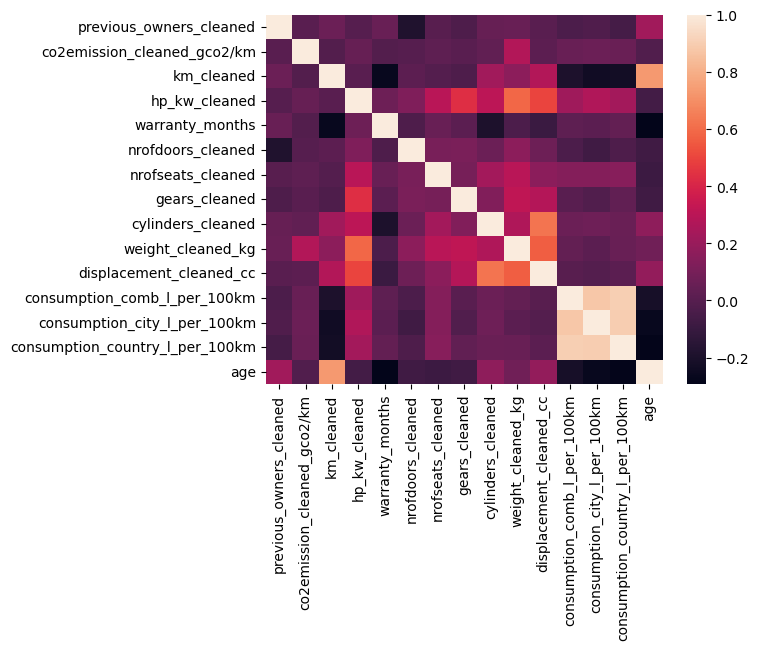

In [16]:
# heatmap of correlations for numeric cols (includes numeric categorical variables like age)
sns.heatmap(df.non_enc_cols.corr()) 

## Try to impute mvs for the cateegorical variables first, then can use these wi groupbys to calculate groped medians for filling the numeric variables

## type_cleaned column 

In [17]:
df['type_cleaned'].isna().sum()

2

In [18]:
df['type_cleaned_filled'] = df['type_cleaned'].fillna(df['type_cleaned'].mode()[0]) 
df['type_cleaned_filled'].value_counts(dropna = False)

Used              11098
New                1650
Pre-registered     1364
Employee's car     1011
Demonstration       796
Name: type_cleaned_filled, dtype: int64

Only 2 missig values, fill with the mode of the column

## previous_owners_cleaned

<AxesSubplot: xlabel='previous_owners_cleaned', ylabel='Count'>

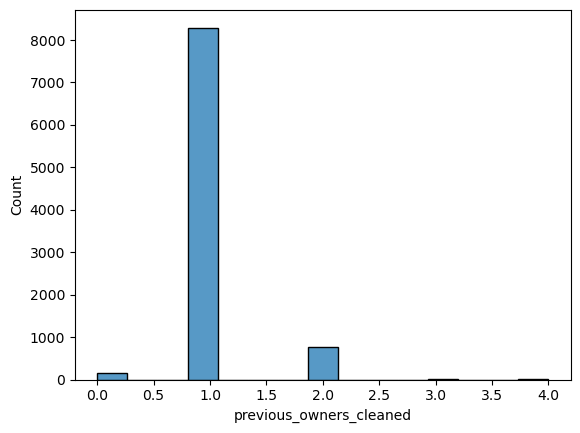

In [19]:
# Look at the distribution of values
sns.histplot(df['previous_owners_cleaned'])

Looks like nans might just be previous_owners = 0, 0s look underrepresented in the data

In [20]:
# compare distribution of nan and values in whether car is new or not
poc_nan = df[df['previous_owners_cleaned'].isna()]
poc_vals = df[~df['previous_owners_cleaned'].isna()]

In [21]:
poc_nan['type_cleaned_filled'].value_counts(dropna = False) # Nearly all the 'New' cars (1496 out of 1650) are in the nans.

Used              4012
New               1496
Pre-registered     519
Employee's car     356
Demonstration      282
Name: type_cleaned_filled, dtype: int64

In [22]:
poc_vals['type_cleaned_filled'].value_counts(dropna = False) 

Used              7086
Pre-registered     845
Employee's car     655
Demonstration      514
New                154
Name: type_cleaned_filled, dtype: int64

In [23]:
# fill nans using info from 'age' and 'type_cleaned_filled' columns
mode_poc = df.groupby(['type_cleaned_filled'])['previous_owners_cleaned'].transform(lambda x: x.mode().iloc[0])
df['previous_owners_cleaned_filled'] = df['previous_owners_cleaned'].fillna(mode_poc)
df['previous_owners_cleaned_filled'].value_counts(dropna = False)

1.0    13463
0.0     1659
2.0      778
3.0       17
4.0        2
Name: previous_owners_cleaned_filled, dtype: int64

## Body cleaned

In [24]:
df['body_cleaned'].value_counts(dropna = False)

Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
NaN                60
Off-Road           56
Coupe              25
Convertible         8
Name: body_cleaned, dtype: int64

In [25]:
mode_body = df.groupby('make_model')['body_cleaned'].transform(lambda x: x.mode().iloc[0]) # Choose the first modal value of the group
df['body_cleaned_filled'] = df['body_cleaned'].fillna(mode_body)

In [26]:
df['body_cleaned_filled'].isna().sum()

0

In [33]:
df['type_cleaned_filled'].isna().sum()

0

## Age column

In [40]:
print(df.age.value_counts(dropna = False))

1.0    4522
3.0    3674
2.0    3273
0.0    2853
NaN    1597
Name: age, dtype: int64


In [46]:
# Fill age column on basis of type_cleaned (also make_model, km_cleaned?)
age_mode = df.groupby(['make_model','type_cleaned_filled'])['age'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) # check if there is a mode, may not be if value unique/all 'age' values are nan in that grouping
df['age_filled'] = df['age'].fillna(age_mode)
print(df.age_filled.value_counts(dropna = False))


1.0    4540
0.0    4393
3.0    3692
2.0    3276
NaN      18
Name: age_filled, dtype: int64


In [47]:
# Fill the remaining 18 nans with a higher grouping, just type_cleaned_filled in this case
remaining_age_mode = df.groupby(['type_cleaned_filled'])['age'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) 
df['age_filled'] = df['age_filled'].fillna(remaining_age_mode)
print(df.age_filled.value_counts(dropna = False))

1.0    4540
0.0    4411
3.0    3692
2.0    3276
Name: age_filled, dtype: int64


## co2_emission_cleaned

In [ ]:
df['gearingtype_cleaned'].value_counts(dropna = False)

Manual            8153
Automatic         7297
Semi-automatic     469
Name: gearingtype_cleaned, dtype: int64

In [ ]:
df['fuel_cleaned'].value_counts(dropna = False)

diesel      7298
super95     4466
gasoline    3731
other        424
Name: fuel_cleaned, dtype: int64

In [ ]:
df.emissionclass_cleaned.value_counts(dropna = False)              

6      10139
NaN     3628
6d      1907
6c       127
5         78
4         40
Name: emissionclass_cleaned, dtype: int64

In [48]:
median_co2 = df.groupby(['make_model', 'fuel_cleaned','gearingtype_cleaned'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.median())
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_gco2/km'].fillna(median_co2)

In [49]:
df['co2emission_cleaned_filled'].isna().sum()

2

In [50]:
# Have 2 leftover nas (no median for that grouping), group by higher grouping and impute based on this. make_model probably most important, start with this
median_co2_leftover = df.groupby(['make_model'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.median())
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_filled'].fillna(median_co2_leftover)
df['co2emission_cleaned_filled'].isna().sum()

1

In [51]:
# Have 2 leftover nas (no median for that grouping), group by higher grouping and impute based on this. make_model probably most important, start with this
median_co2_leftover2 = df.groupby(['fuel_cleaned'])['co2emission_cleaned_gco2/km'].transform(lambda x: x.median())
df['co2emission_cleaned_filled'] = df['co2emission_cleaned_filled'].fillna(median_co2_leftover2)
df['co2emission_cleaned_filled'].isna().sum()

0

In [ ]:
## emission_class column

In [ ]:
mode_emissionclass = df.groupby(['make_model', 'fuel_cleaned'])['emissionclass_cleaned'].transform(lambda x: x.mode().iloc[0])
df['emissionclass_cleaned_filled'] = df['emissionclass_cleaned'].fillna(mode_emissionclass)

In [ ]:
df['emissionclass_cleaned_filled'].value_counts(dropna= False)

6     13746
6d     1926
6c      127
5        78
4        42
Name: emissionclass_cleaned_filled, dtype: int64

In [ ]:
# Drop all of the 'cleaned' columns that now have 'cleaned_filled' versions
# df.drop(['previous_owners_cleaned', type_cleaned], axis = 1, inplace = True)


## km_cleaned column

In [ ]:
median_group_km = df.groupby(['make_model','body_cleaned','age'])['km_cleaned'].transform(lambda x: x.median())

df['km_cleaned_filled'] = df['km_cleaned'].fillna(median_group_km)
df['km_cleaned_filled'].value_counts(dropna = False)

10.0       1076
NaN         841
1.0         367
5.0         174
50.0        167
           ... 
36020.0       1
53433.0       1
67469.0       1
43197.0       1
57.0          1
Name: km_cleaned_filled, Length: 6692, dtype: int64

In [ ]:
df[['km_cleaned_filled', 'km_cleaned']].sample(20)
df[df['km_cleaned'].isna()]['km_cleaned_filled'].value_counts(dropna = False)

NaN        841
36.0        41
10.0        31
50.0        19
13587.5     14
1500.0      12
178.0        8
500.0        7
15.0         7
7000.0       6
10564.0      5
2000.0       5
5.0          4
11.0         4
775.5        3
12000.0      3
3000.0       3
10780.0      3
19800.0      2
31000.0      1
25150.0      1
28000.0      1
35.0         1
7.0          1
18000.0      1
Name: km_cleaned_filled, dtype: int64

## consumption city, country, comb

In [ ]:
cc = df[['consumption_city_l_per_100km', 'consumption_comb_l_per_100km', 'consumption_country_l_per_100km',]]
cc.isna().sum()

consumption_city_l_per_100km       3303
consumption_comb_l_per_100km       2914
consumption_country_l_per_100km    3243
dtype: int64